In [32]:
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as DCUtils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
# from PGI_DC_example_Utils import plot_pseudoSection, getCylinderPoints

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

3.11.3 (main, Apr 19 2023, 23:54:32) [GCC 11.2.0]


In [33]:
# 2D Mesh
#########
csx,  csy,  csz = 0.25,  0.25,  0.25
# Number of core cells in each direction
ncx,  ncz = 123,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

# 2-cylinders Model Creation
##########################
# Spheres parameters
x0,  z0,  r0 = -6.,  -5.,  3.
x1,  z1,  r1 = 6.,  -5.,  3.

ln_sigback = -np.log(500.)
ln_sigc = -np.log(90.)
ln_sigr = -np.log(50.)

# Add some variability to the physical property model
noisemean = 0.
noisevar = np.sqrt(0.001)
ln_over = -2.

mtrue = ln_sigback * np.ones(mesh.nC) + norm(noisemean, noisevar).rvs(mesh.nC)
mprim = copy.deepcopy(mtrue)

csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))

# Define the sphere limit
rsph = (np.sqrt((mesh.gridCC[:, 1] - z1) **
                2. + (mesh.gridCC[:, 0] - x1)**2.)) < r1
mtrue[rsph] = ln_sigr * np.ones_like(mtrue[rsph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[rsph]).shape))

# sphere smaller but higher conductivity
csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))


mtrue = utils.mkvc(mtrue)
xmin,  xmax = -15., 15
ymin,  ymax = -15., 0.
#xmin,  xmax = mesh.vectorNx.min(), mesh.vectorNx.max()
#ymin,  ymax = mesh.vectorNy.min(), mesh.vectorNy.max()
print(xmin,xmax,ymin,ymax)
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = discretize.utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)

-15.0 15 -15.0 0.0


/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/discretize/utils/code_utils.py:307: FutureWarning: ExtractCoreMesh has been deprecated, please use extract_core_mesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/discretize/utils/code_utils.py:264: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/discretize/mixins/mpl_mod.py:305: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  warnings.warn(


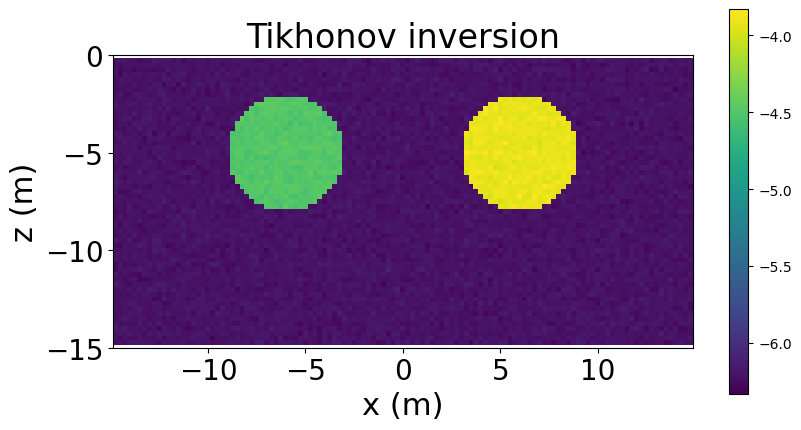

In [34]:
clim = [mtrue.min(), mtrue.max()]

fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mtrue[actcore], ax=ax, clim=clim, pcolorOpts={'cmap':"viridis"})
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0])
plt.show()

In [35]:
# Setup a Dipole-Dipole Survey with 1m and 2m dipoles
xmin, xmax = -15., 15.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
survey1 = DCUtils.generate_dcip_survey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=1, b=1, n=16, d2flag='2.5D'
)
survey2 = DCUtils.generate_dcip_survey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=2, b=2, n=16, d2flag='2.5D'
)

survey = dc.Survey(survey1.source_list + survey2.source_list)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    mesh=mesh,  indActive=actcore,
    valInactive=-np.log(1e8)
)
mapping = expmap * mapactive
sim = dc.Simulation2DNodal(
    mesh,
    survey,
    sigmaMap=mapping,
    storeJ=True,
    solver=Solver
)


std = 0.02
# survey.dpred(mtrue[actcore])
dpred = sim.make_synthetic_data(mtrue[actcore], relative_error=std, force=True)
survey.eps = 1e-4

m0 = -np.log(np.median((DCUtils.apparent_resistivity_from_voltage(survey, dpred.dobs)))) * np.ones(mapping.nP)

# expmap = Maps.ExpMap(mesh)
# mapactive = Maps.InjectActiveCells(
#     mesh=mesh,  indActive=actcore,
#     valInactive=np.unique(m0)
# )
# mapping = expmap * mapactive
# problem = DC.Problem2D_N(mesh,  sigmaMap=mapping, storeJ=True)
# survey.unpair()
# problem.pair(survey)
# problem.Solver = PardisoSolver

/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:755: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:782: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/discretize/utils/matrix_utils.py:445: FutureWarning: The `dir` keyword argument has been renamed to `bdir` to avoid shadowing the builtin variable `dir`. This will be removed in discretize 1.0.0
  warnings.warn(


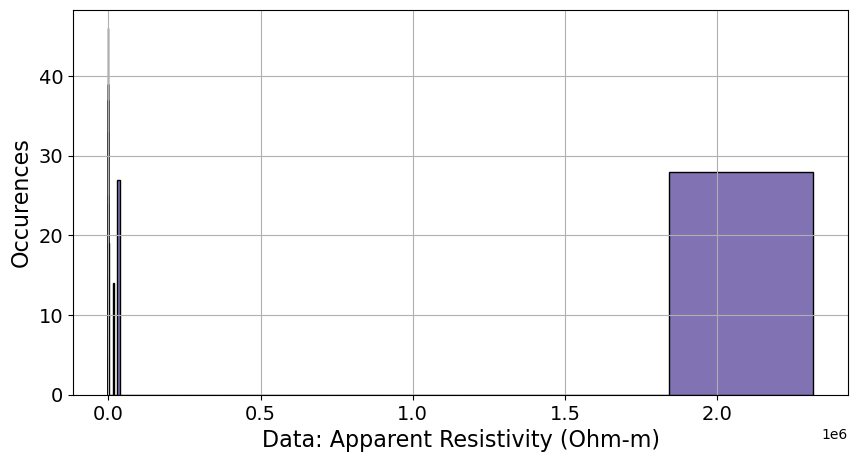

In [38]:
# Plot the histogram of the data
fig, ax = plt.subplots(1,1,figsize=(10,5))
hist, edges = np.histogram(-np.log(((DCUtils.apparent_resistivity_from_voltage(survey, dpred.dobs)))),bins=50, density=False)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="k", align="edge",color='#8172B3');
# ax.plot((1./np.exp(-4.72760309)*np.ones(2)),[0,50],linestyle='dashed',linewidth=2.,c='k')
# ax.text(115,30,'Starting half-space\nwhen no mean\npetrophysical information\nis available',fontsize=16)
# ax.plot(100.*np.ones(2),[0,50],linestyle='dashed',linewidth=2.,c='k')
# ax.text(98,20,'True\nbackground\nmean',fontsize=16,ha='right')
ax.grid(True,which='both')
ax.grid(True,which="major",ls="-")

ax.set_xlabel('Data: Apparent Resistivity (Ohm-m)',fontsize=16)
ax.tick_params(labelsize=14)
ax.set_ylabel('Occurences',fontsize=16)
# ax.set_xticks(np.r_[75,100,125,150])
plt.show()

In [39]:
# Generate the GMM petrophysical distribution
n = 3
gmmref = utils.WeightedGaussianMixture(
    
    n_components=n,
    mesh=mesh,
    actv=actcore,
    covariance_type='full',
    max_iter=1000,
    n_init=10,
    reg_covar=4e-3,

)

gmmref.fit(mtrue[actcore].reshape(-1, 1))

gmmref.means = np.r_[-np.log(50.), -np.log(90.), -np.log(500.)][:,np.newaxis]

gmmref.covariances_ = np.array([[[0.001]],
                             [[0.001]],
                             [[0.001]],])

gmmref.compute_clusters_precisions()

(0.0, 12.0)

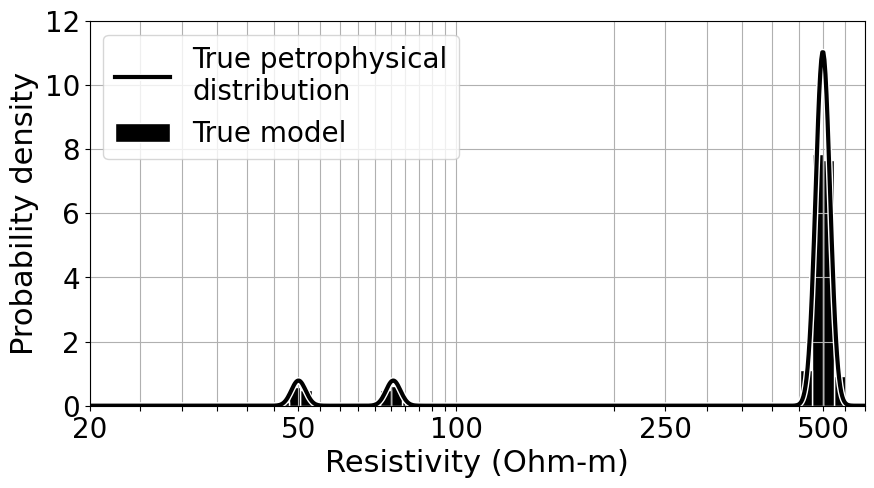

In [40]:
# Plot the histogram of the true model with the petrophysical distribution
fig, ax = plt.subplots(1,1,figsize=(10,5))
testXplot = np.logspace(1, 3, 1000,base=10)[:,np.newaxis]

ax.plot(testXplot, np.exp(gmmref.score_samples(-np.log(testXplot))),linewidth=3,label='True petrophysical\ndistribution',c='k',
       path_effects=[pe.Stroke(linewidth=5, foreground='w'), pe.Normal()])
ax.set_xlabel('Resistivity (Ohm-m)',fontsize=22)
ax.tick_params(labelsize=20)
ax.set_ylabel('Probability density',fontsize=22)
ax.set_xscale('log')
ax.grid(True,which='major')
ax.grid(True,which="major",ls="-")
ticks = np.r_[np.linspace(2,10,17)*10,np.linspace(2,9,15)*100]
tickslist = list(ticks)
tcklbl = [''] * len(tickslist)
tcklbl[np.where(ticks==20)[0][0]] = '20'
tcklbl[np.where(ticks==50)[0][0]] = '50'
tcklbl[np.where(ticks==100)[0][0]] = '100'
tcklbl[np.where(ticks==250)[0][0]] = '250'
tcklbl[np.where(ticks==500)[0][0]] = '500'
ax.set_xticks(tickslist)
ax.set_xticklabels(tcklbl)
ax.set_xlim([20,600])
hist, edges = np.histogram(mtrue[actcore],bins=50, density=True)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="w", align="edge",label='True model',color='k')
ax.legend(loc=0,fontsize=20)
ax.set_ylim([0.,12.])

In [14]:
# Setup the inversion proceedure
# Define a counter
# Data misfit
dmis = data_misfit.L2DataMisfit(data=dpred, simulation=sim)
# Regularization
regmap = maps.IdentityMap(nP=int(actcore.sum()))
# reg = regularization.Sparse(mesh, indActive=active, mapping=regmap)

reg = regularization.WeightedLeastSquares(
    mesh, 
    active_cells=actcore,
    mapping=regmap,
    reference_model=m0
)
reg.alpha_s = 1/csx**2
reg.alpha_x = 100
reg.alpha_y = 100
reg.alpha_z = 100

# Optimization object
opt = optimization.ProjectedGNCG(maxIter=10, lower=-10, upper=10,
                                 maxIterLS=20, maxIterCG=100, tolCG=1e-5)

opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg,  opt)
invProb.beta = 1e2

# Inversion directives
Target = directives.TargetMisfit()
betaSched = directives.BetaSchedule(coolingFactor=2.,  coolingRate=1.)
updateSensW = directives.UpdateSensitivityWeights(threshold=1e-3,everyIter=False)
update_Jacobi = directives.UpdatePreconditioner()
inv = inversion.BaseInversion(invProb,  directiveList=[updateSensW, 
                                                       Target,
                                                       betaSched,
                                                       update_Jacobi,
                                                       ])

import time
start = time.time()
# Run the inversion
mopt = inv.run(m0)
print('Inversion took {0} seconds'.format(time.time() - start))

/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/directives/directives.py:2519: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  warnings.warn(
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/directives/directives.py:2526: UserWarning: 'threshold' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'threshold_value'.
  warnings.warn(



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+02  8.36e+04  0.00e+00  8.36e+04    8.68e+02      0              
   1  5.00e+01  5.10e+03  5.80e+01  8.00e+03    3.43e+02      0              
   2  2.50e+01  1.15e+03  8.79e+01  3.35e+03    1.62e+02      0              
   3  1.25e+01  3.91e+02  1.07e+02  1.72e+03    1.01e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 8.3580e+03
1 : |xc-x_last| = 7.4242e+00 <= tolX*(1+|x0|) = 4.6312e+01
0 : |proj(x-g)-x|

/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/discretize/utils/code_utils.py:264: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/discretize/mixins/mpl_mod.py:305: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  warnings.warn(


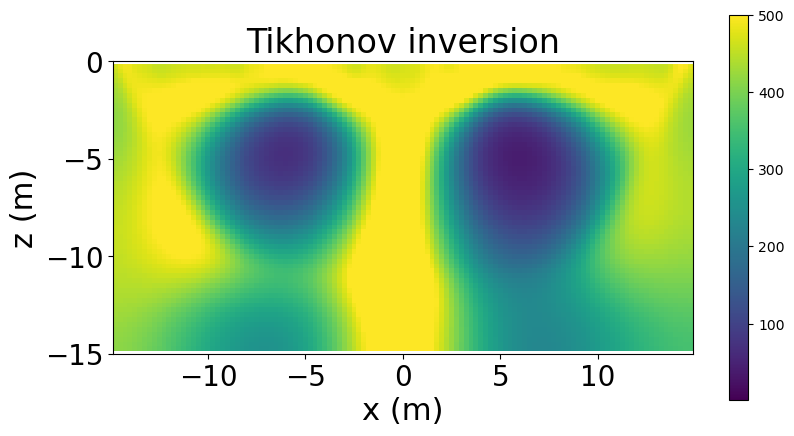

In [15]:
# Plot the recovered model
clim = [1, 500]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(1 / np.exp(mopt), ax=ax, clim=clim, pcolorOpts={'cmap':"viridis"})
plt.colorbar(dat[0])
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)

(0.0, 1.0, 0.0, 1.0)

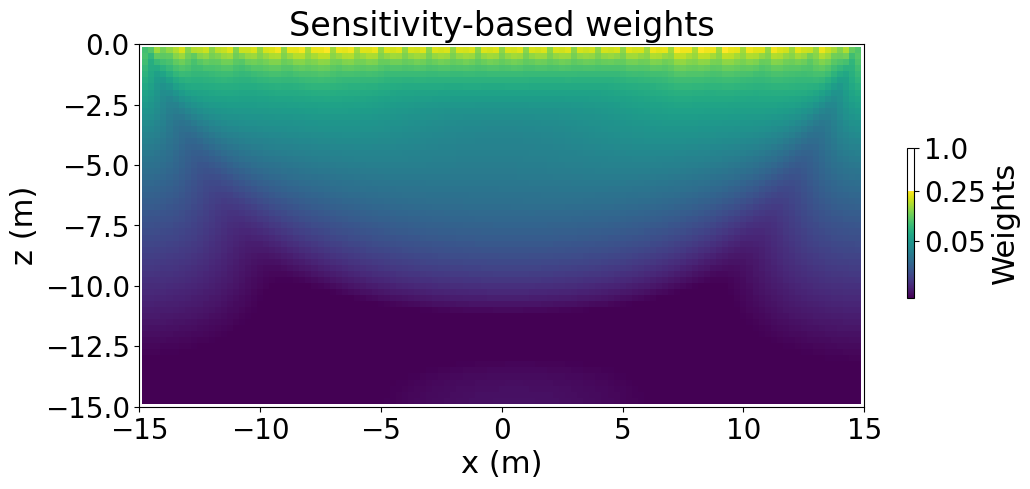

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sensweights = sp.csr_matrix.diagonal(reg.objfcts[0].W)
dat = meshCore.plotImage(np.log(sensweights), ax=ax)
ax.set_title('Sensitivity-based weights',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlim([-15,15])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = plt.colorbar(dat[0], ax=cbar_ax)
cb.set_label('Weights',fontsize=22)
cb.set_ticks([np.log(0.05),np.log(0.25),np.log(1)], )
cb.set_ticklabels([0.05,0.25,1.],)
cb.ax.tick_params(labelsize=20)
cbar_ax.axis('off')

(0.0, 12.0)

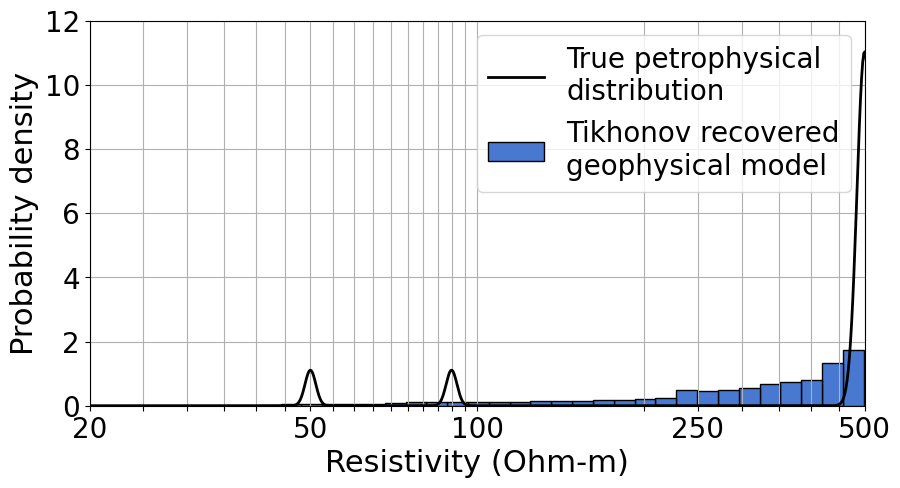

In [17]:
# Plot the histogram of the Tikhonov recovered model

fig, ax = plt.subplots(1,1,figsize=(10,5))

testXplot = np.logspace(1, 3, 1000,base=10)[:,np.newaxis]

ax.plot(testXplot, np.exp(gmmref.score_samples(-np.log(testXplot))),
        linewidth=2,label='True petrophysical\ndistribution',c='k'
)
ax.set_xlabel('Resistivity (Ohm-m)',fontsize=22)
ax.tick_params(labelsize=20)
ax.set_ylabel('Probability density',fontsize=22)
ax.set_xscale('log')
ax.grid(True,which='both')
ax.grid(True,which="major",ls="-")
ticks = np.r_[np.linspace(2,10,17)*10,np.linspace(2,9,15)*100]
tickslist = list(ticks)
tcklbl = [''] * len(tickslist)
tcklbl[np.where(ticks==20)[0][0]] = '20'
tcklbl[np.where(ticks==50)[0][0]] = '50'
tcklbl[np.where(ticks==100)[0][0]] = '100'
tcklbl[np.where(ticks==250)[0][0]] = '250'
tcklbl[np.where(ticks==500)[0][0]] = '500'
ax.set_xticks(tickslist)
ax.set_xticklabels(tcklbl)
ax.set_xlim([20,500])
hist, edges = np.histogram(mopt,bins=32, density=True)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), 
       ec="k", align="edge",label='Tikhonov recovered\ngeophysical model',color='#4878CF'
)
ax.legend(loc=0,fontsize=20)
ax.set_ylim([0.,12.])

In [45]:
log_conductivity_background = np.log(1 / 500)

m0 = log_conductivity_background * np.ones(mapping.nP)
# Create the regularization with GMM information
idenMap = maps.IdentityMap(nP=m0.shape[0])
wires = maps.Wires(('m', m0.shape[0]))
reg_mean = regularization.PGI(
    gmmref=gmmref,  mesh=mesh,
    wiresmap=wires,
    maplist=[idenMap],
    reference_model=m0,
    indActive=actcore
)

# Weighting
reg_mean.alpha_s = 0.016
reg_mean.alpha_x = 100
reg_mean.alpha_y = 100
# reg_mean.mrefInSmooth = True
# reg_mean.approx_gradient = True


# Optimization
opt = optimization.ProjectedGNCG(maxIter=20, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=20, )
opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg_mean,  opt)

# Inversion directives
betaIt = directives.PGI_BetaAlphaSchedule(
    verbose=True, coolingFactor=5.,
    warmingFactor=1., tolerance=0.05,
    progress=0.1
)
targets = directives.MultiTargetMisfits(
    TriggerSmall=True,
    TriggerTheta=False,
    verbose=True,
)
MrefInSmooth = directives.PGI_AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)
petrodir = directives.PGI_UpdateParameters(
    update_covariances=True,
    kappa = 1e8,
    nu = 1e8,
    update_reference_model=(False)
    )
updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
update_Jacobi = directives.UpdatePreconditioner()
invProb.beta = 1e-2
inv = inversion.BaseInversion(invProb,
                              directiveList=[
                                            #  updateSensW,
                                             petrodir,
                                             targets, betaIt,
                                             MrefInSmooth,
                                            #  update_Jacobi,
                                             ])

# Run!
mcluster = inv.run(m0)

/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/utils/code_utils.py:642: FutureWarning: active_cells.indActive has been deprecated, please use active_cells. It will be removed in version 0.19.0 of SimPEG.
  warnings.warn(message, FutureWarning)
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/utils/code_utils.py:651: FutureWarning: active_cells.indActive has been deprecated, please use active_cells. It will be removed in version 0.19.0 of SimPEG.
  warnings.warn(message, FutureWarning)
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/directives/directives.py:2519: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  warnings.warn(
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/directives/directives.py:2526: UserWarning: 'threshold' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'threshold_value'.
  warnings.warn(



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
<class 'SimPEG.regularization.pgi.PGIsmallness'>
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-02  7.61e+05  0.00e+00  7.61e+05    8.56e+04      0              
geophys. misfits: 77342.9 (target 209.5 [False]) | smallness misfit: 189897.4 (target: 3510.5 [False])
Beta cooling evaluation: progress: [77342.9]; minimum progress targets: [684655.8]
mref changed in  10  places
   1  1.00e-02  7.73e+04  1.19e+04  7.75e+04    1.37e+04      0              
geophys. misfits: 14081.1 (target 209.5 [False]) | smallness misfit: 461270.3 (targe

/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/discretize/utils/code_utils.py:264: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/discretize/mixins/mpl_mod.py:305: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  warnings.warn(


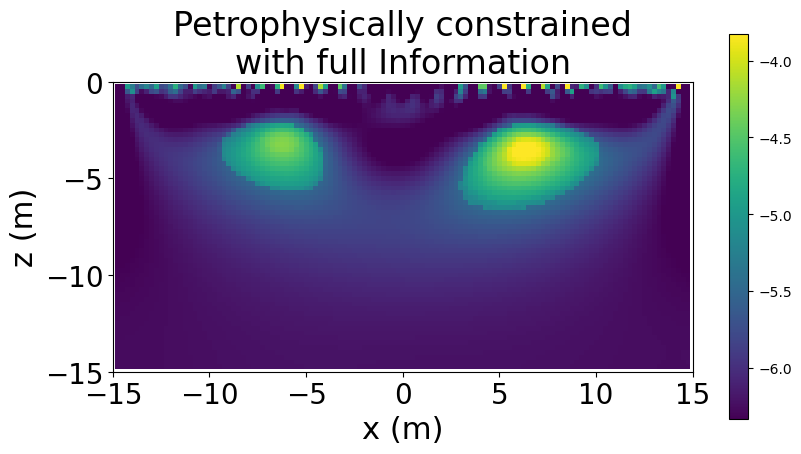

In [46]:
clim = [mtrue.min(), mtrue.max()]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mcluster, ax=ax, clim=clim, pcolorOpts={'cmap':"viridis"})
plt.colorbar(dat[0])
ax.set_title('Petrophysically constrained\nwith full Information',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlim([-15,15])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
plt.show()

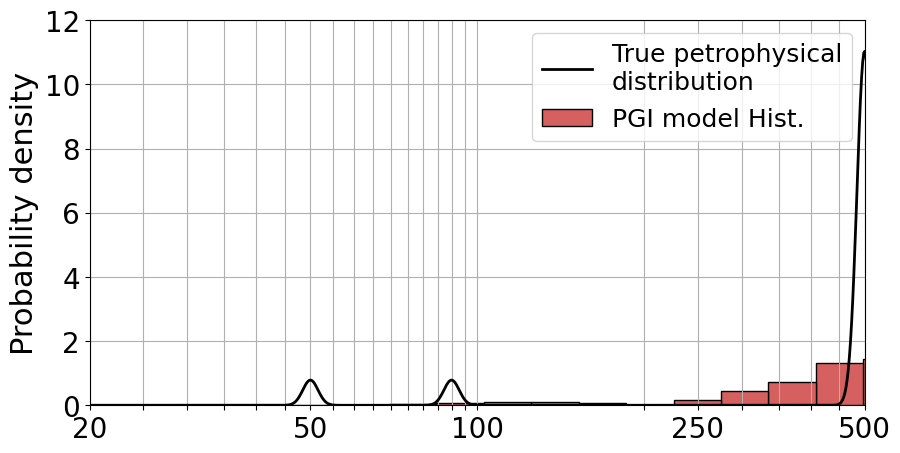

In [48]:
# plot the histogram of the PGI recovered model
fig, ax = plt.subplots(1,1,figsize=(10,5))
testXplot = np.logspace(1, 3, 1000,base=10)[:,np.newaxis]
ax.plot(testXplot, np.exp(gmmref.score_samples(-np.log(testXplot))),linewidth=2,label='True petrophysical\ndistribution',c='k')
ax.tick_params(labelsize=20)
ax.set_ylabel('Probability density',fontsize=22)
ax.set_xscale('log')
ax.grid(True,which='both')
ax.grid(True,which="major",ls="-")
ticks = np.r_[np.linspace(2,10,17)*10,np.linspace(2,9,15)*100]
tickslist = list(ticks)
tcklbl = [''] * len(tickslist)
tcklbl[np.where(ticks==20)[0][0]] = '20'
tcklbl[np.where(ticks==50)[0][0]] = '50'
tcklbl[np.where(ticks==100)[0][0]] = '100'
tcklbl[np.where(ticks==250)[0][0]] = '250'
tcklbl[np.where(ticks==500)[0][0]] = '500'
ax.set_xticks(tickslist)
ax.set_xticklabels(tcklbl)
ax.set_xlim([20,500])
hist, edges = np.histogram(mcluster,bins=32, density=True)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="k", align="edge",label='PGI model Hist.',color='#d65f5f')
ax.legend(loc=0,fontsize=18)
ax.set_ylim([0.,12])
plt.show()

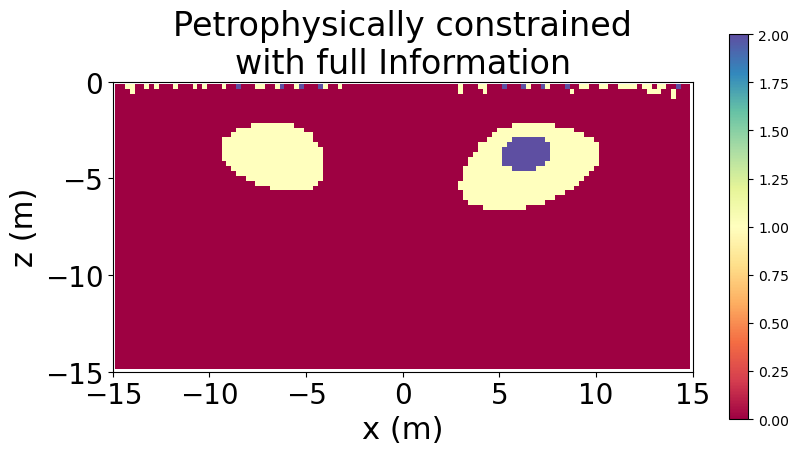

In [51]:
classification = reg_mean.compute_quasi_geology_model()

# clim = [mtrue.min(), mtrue.max()]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(classification, ax=ax, pcolorOpts={'cmap':"Spectral"})
plt.colorbar(dat[0])
ax.set_title('Petrophysically constrained\nwith full Information',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlim([-15,15])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
plt.show()

# creating variations on the model

In [36]:
import itertools
import random
import numpy as np



In [42]:
# ----------------------------------------------------------------------------------------------

# loop over many placements

#

x = -np.arange(-12, 12.5, 0.5)
z = -np.arange(4, 7.5, 0.5)
res = random.randint(1,90)

# set background unit
log_conductivity_background = -np.log(500)

print(res)

models = []
pgi_geomodel = []

count = 0

for xi, xi1, zi, zi1 in itertools.product(x, x, z, z):

    # print(xi, zi)
    if np.abs(xi - xi1) > 6.5:

        #   2-cylinders Model Creation
        
        # Spheres parameters
        x0,  z0,  r0 = xi,  zi,  3.
        x1,  z1,  r1 = xi1,  zi1,  3.

        ln_sigback = log_conductivity_background
        ln_sigc = -np.log(random.randint(1,90))
        ln_sigr = -np.log(random.randint(1,90))

        # Add some variability to the physical property model
        noisemean = 0.
        noisevar = np.sqrt(0.001)
        ln_over = -2.

        mtrue = ln_sigback * np.ones(mesh.nC) + norm(noisemean, noisevar).rvs(mesh.nC)
        mprim = copy.deepcopy(mtrue)

        csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                        2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
        mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph]) + \
            norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))

        # Define the sphere limit
        rsph = (np.sqrt((mesh.gridCC[:, 1] - z1) **
                        2. + (mesh.gridCC[:, 0] - x1)**2.)) < r1
        mtrue[rsph] = ln_sigr * np.ones_like(mtrue[rsph]) + \
            norm(noisemean, noisevar).rvs(np.prod((mtrue[rsph]).shape))

        # sphere smaller but higher conductivity
        csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                        2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
        mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph]) + \
            norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))


        models.append(utils.mkvc(mtrue))

        # -----------------------------------------------------------------

        # forward

        #

        dpred = sim.make_synthetic_data(mtrue[actcore], relative_error=std, force=True)

        # Data misfit
        dmis = data_misfit.L2DataMisfit(data=dpred, simulation=sim)

        # -----------------------------------------------------------------

        # gmm

        #

        # Generate the GMM petrophysical distribution
        n = 3
        gmmref = utils.WeightedGaussianMixture(
            
            n_components=n,
            mesh=mesh,
            actv=actcore,
            covariance_type='full',
            max_iter=1000,
            n_init=10,
            reg_covar=4e-3,

        )

        gmmref.fit(mtrue[actcore].reshape(-1, 1))

        gmmref.means = np.r_[ln_sigc, ln_sigr, ln_sigback][:,np.newaxis]

        gmmref.covariances_ = np.array([[[0.001]],
                                    [[0.001]],
                                    [[0.001]],])

        gmmref.compute_clusters_precisions()

        # -----------------------------------------------------------------

        # inversion

        #

        m0 = log_conductivity_background * np.ones(mapping.nP)
        # Create the regularization with GMM information
        idenMap = maps.IdentityMap(nP=m0.shape[0])
        wires = maps.Wires(('m', m0.shape[0]))
        reg_mean = regularization.PGI(
            gmmref=gmmref,  mesh=mesh,
            wiresmap=wires,
            maplist=[idenMap],
            reference_model=m0,
            indActive=actcore
        )

        # Weighting
        reg_mean.alpha_s = 0.016
        reg_mean.alpha_x = 100
        reg_mean.alpha_y = 100
        # reg_mean.mrefInSmooth = True
        # reg_mean.approx_gradient = True


        # Optimization
        opt = optimization.ProjectedGNCG(maxIter=20, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=20, )
        opt.remember('xc')

        # Set the inverse problem
        invProb = inverse_problem.BaseInvProblem(dmis,  reg_mean,  opt)

        # Inversion directives
        betaIt = directives.PGI_BetaAlphaSchedule(
            verbose=True, coolingFactor=5.,
            warmingFactor=1., tolerance=0.05,
            progress=0.1
        )
        targets = directives.MultiTargetMisfits(
            TriggerSmall=True,
            TriggerTheta=False,
            verbose=True,
        )
        MrefInSmooth = directives.PGI_AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)
        petrodir = directives.PGI_UpdateParameters(
            update_covariances=True,
            kappa = 1e8,
            nu = 1e8,
            update_reference_model=(False)
            )
        updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
        update_Jacobi = directives.UpdatePreconditioner()
        invProb.beta = 1e-2
        inv = inversion.BaseInversion(invProb,
                                    directiveList=[
                                                    #  updateSensW,
                                                    petrodir,
                                                    targets, betaIt,
                                                    MrefInSmooth,
                                                    #  update_Jacobi,
                                                    ])

        # Run!
        mcluster = inv.run(m0)

        # get the quasi geo-model
        pgi_geomodel.append(reg_mean.compute_quasi_geology_model())

        np.save(f'./training/true_model{count}.npy', utils.mkvc(mtrue))
        np.save(f'./training/pgi_model{count}.npy', reg_mean.compute_quasi_geology_model())

        count += 1

        


19


/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/utils/code_utils.py:642: FutureWarning: active_cells.indActive has been deprecated, please use active_cells. It will be removed in version 0.19.0 of SimPEG.
  warnings.warn(message, FutureWarning)
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/utils/code_utils.py:651: FutureWarning: active_cells.indActive has been deprecated, please use active_cells. It will be removed in version 0.19.0 of SimPEG.
  warnings.warn(message, FutureWarning)
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/directives/directives.py:2519: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  warnings.warn(
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/directives/directives.py:2526: UserWarning: 'threshold' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'threshold_value'.
  warnings.warn(



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
<class 'SimPEG.regularization.pgi.PGIsmallness'>
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-02  2.98e+06  0.00e+00  2.98e+06    4.52e+05      0              
geophys. misfits: 418071.7 (target 209.5 [False]) | smallness misfit: 181447.8 (target: 3510.5 [False])
Beta cooling evaluation: progress: [418071.7]; minimum progress targets: [2684871.1]
mref changed in  96  places
   1  1.00e-02  4.18e+05  1.13e+04  4.18e+05    1.04e+05      0              
geophys. misfits: 179493.0 (target 209.5 [False]) | smallness misfit: 301673.6 (t

In [28]:
print(len(models))

61740


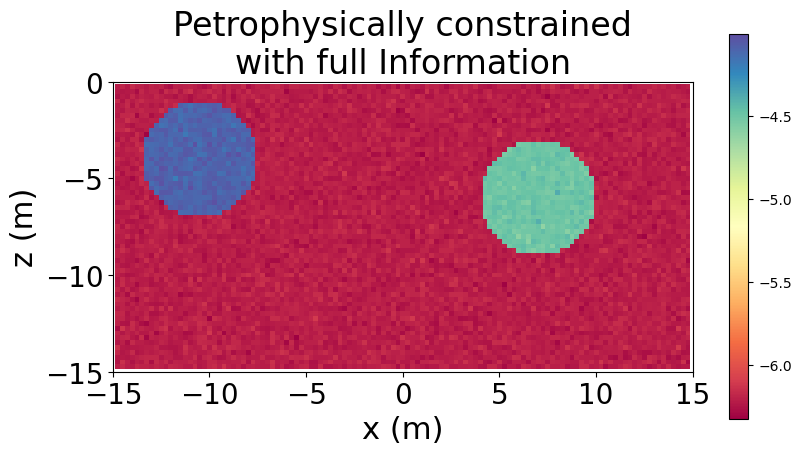

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(models[16002][actcore], ax=ax, pcolorOpts={'cmap':"Spectral"})
plt.colorbar(dat[0])
ax.set_title('Petrophysically constrained\nwith full Information',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlim([-15,15])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
plt.show()